In this Notebook, let's try to understand how we develop QSAR for our curated data using ML models:

Models that we explore are:

- Random Forest Regressor
- Gradient Boosting Regressor
- Xgboost


Let's load the libraries for handling data and model building

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from numpy.typing import ArrayLike
from typing import List, Union, Dict

Loading rdkit for feature extraction

In [2]:
from rdkit import Chem
from rdkit.Chem import rdPartialCharges

Let's create function for extracting different features from the smiles 

In [6]:
def mols_from_smiles(smiles: List[str]):
    """ Create a list of RDkit mol objects from a list of SMILES strings """
    from rdkit.Chem import MolFromSmiles
    return [MolFromSmiles(m) for m in smiles]


def rdkit_numpy_convert(fp):
    """ Convert a RDkit fingerprint object to simple numpy array """
    from rdkit.DataStructs import ConvertToNumpyArray
    output = []
    for f in fp:
        arr = np.zeros((1,))
        ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)



Converting the SMILES to ECFP fingerprints

In [4]:
def ecfp(smiles: List[str], radius: int = 2, nbits: int = 1024):
    """ Convert SMILES to ECFP fingerprints """
    from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

    fp = [GetMorganFingerprintAsBitVect(m, radius, nBits=nbits) for m in mols_from_smiles(smiles)]
    return rdkit_numpy_convert(fp)

Convert SMILES to MACCs fingerprints

In [5]:
def maccs(smiles: List[str]):
    """ """
    from rdkit.Chem import MACCSkeys

    fp = [MACCSkeys.GenMACCSKeys(m) for m in mols_from_smiles(smiles)]
    return rdkit_numpy_convert(fp)

Calculate drug-like physchem descriptors from a rdkit mol object. 

In [14]:
def compute_physchem(smiles: List[str]):

    from rdkit.Chem import Descriptors
    from rdkit import Chem

    X = []
    for m in mols_from_smiles(smiles):
        weight = Descriptors.ExactMolWt(m)
        logp = Descriptors.MolLogP(m)
        h_bond_donor = Descriptors.NumHDonors(m)
        h_bond_acceptors = Descriptors.NumHAcceptors(m)
        rotatable_bonds = Descriptors.NumRotatableBonds(m)
        atoms = Chem.rdchem.Mol.GetNumAtoms(m)
        heavy_atoms = Chem.rdchem.Mol.GetNumHeavyAtoms(m)
        molar_refractivity = Chem.Crippen.MolMR(m)
        topological_polar_surface_area = Chem.QED.properties(m).PSA
        formal_charge = Chem.rdmolops.GetFormalCharge(m)
        rings = Chem.rdMolDescriptors.CalcNumRings(m)

        X.append(np.array([weight, logp, h_bond_donor, h_bond_acceptors, rotatable_bonds, atoms, heavy_atoms,
                           molar_refractivity, topological_polar_surface_area, formal_charge, rings]))

    return np.array(X)

Load the data

In [8]:
df=pd.read_csv("Chembl_pIC50_curated.csv")

In [9]:
df.head()

,assay,std_type,SMILES,std_value,std_units,standard_relation,molecule_chembl_id,activity_type,structure_curated,substance_type_name,pIC50
0,Inhibition of A-beta-42 production by inhibiti...,IC50,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,nM,=,CHEMBL311039,active,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,organic,5.301030
1,Inhibition of A-beta-42 production by inhibiti...,IC50,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,nM,=,CHEMBL450926,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,organic,5.568636
2,Inhibition of A-beta-42 production by inhibiti...,IC50,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,nM,=,CHEMBL310242,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,organic,5.744727
3,Inhibition of A-beta-42 production by inhibiti...,IC50,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,nM,=,CHEMBL74874,inactive,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,organic,4.958607
4,Inhibition of A-beta-42 production by inhibiti...,IC50,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,nM,=,CHEMBL75183,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,organic,5.000000


Now that we have the data, let's extract 3 different features:

1. ECFP fingerprints
2. MACCS fingerprints
3. physchem descriptors [ weight, logp, h_bond_donor, h_bond_acceptors, rotatable_bonds, atoms, heavy_atoms,
                           molar_refractivity, topological_polar_surface_area, formal_charge, rings]

1. ECFP Fingerprints

In [12]:
ecfp_data=pd.DataFrame(ecfp(df['structure_curated']))
ecfp_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
maccs_data=pd.DataFrame(maccs(df['structure_curated']))
maccs_data.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [25]:
physchem_data=pd.DataFrame(compute_physchem(df['structure_curated']),columns=[ "weight", "logp", "h_bond_donor", "h_bond_acceptors", "rotatable_bonds", "atoms", "heavy_atoms",
                           "molar_refractivity", "topological_polar_surface_area", "formal_charge", "rings"])
physchem_data.head()

,weight,logp,h_bond_donor,h_bond_acceptors,rotatable_bonds,atoms,heavy_atoms,molar_refractivity,topological_polar_surface_area,formal_charge,rings
0,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
1,299.101371,3.2412,1.0,3.0,3.0,19.0,19.0,77.6575,46.17,0.0,3.0
2,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
3,327.105978,3.8331,1.0,2.0,3.0,21.0,21.0,84.7905,46.17,0.0,3.0
4,371.055462,3.9422,1.0,2.0,3.0,21.0,21.0,87.4805,46.17,0.0,3.0


Let's save each data set

In [20]:
df[['structure_curated','pIC50']]

,structure_curated,pIC50
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000
...,...,...
1125,C[C@@]1(c2cc(NC(=O)c3ncc(Cl)cc3Cl)ccc2F)CO[C@@...,7.657577
1126,C[C@@]1(c2cc(NC(=O)c3ccc(Br)cn3)ccc2F)CO[C@@](...,7.657577
1127,C[C@@]1(c2cc(NC(=O)c3ccc(Br)cn3)ccc2F)CO[C@@](...,7.657577
1128,Cc1cc(C#N)cnc1C(=O)Nc1ccc(F)c([C@]2(C)CO[C@@](...,8.522879


In [23]:
ecfp_final_data = pd.concat((df[['structure_curated','pIC50']],ecfp_data),axis=1).rename(columns={"structure_curated":"SMILES"})
ecfp_final_data.head()

,SMILES,pIC50,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
ecfp_final_data.to_csv("Chembl_pIC50_ecfp.csv",index=False)

In [29]:
maccs__final_data = pd.concat((df[['structure_curated','pIC50']],maccs_data),axis=1).rename(columns={"structure_curated":"SMILES"})
maccs__final_data.head()

,SMILES,pIC50,0,1,2,3,4,5,6,7,...,157,158,159,160,161,162,163,164,165,166
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [30]:
maccs__final_data.to_csv("Chembl_pIC50_maccs.csv",index=False)

In [31]:

physchem__final_data = pd.concat((df[['structure_curated','pIC50']],physchem_data),axis=1).rename(columns={"structure_curated":"SMILES"})
physchem__final_data.head()

,SMILES,pIC50,weight,logp,h_bond_donor,h_bond_acceptors,rotatable_bonds,atoms,heavy_atoms,molar_refractivity,topological_polar_surface_area,formal_charge,rings
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,299.101371,3.2412,1.0,3.0,3.0,19.0,19.0,77.6575,46.17,0.0,3.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,327.105978,3.8331,1.0,2.0,3.0,21.0,21.0,84.7905,46.17,0.0,3.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,371.055462,3.9422,1.0,2.0,3.0,21.0,21.0,87.4805,46.17,0.0,3.0


In [32]:
physchem__final_data.to_csv("Chembl_pIC50_physchem.csv",index=False)

Let's create separate datasets for different features and develop different ML models and compare them. 

## ECFP data with RandomForestRegressor

In [33]:
ecfp_final_data = pd.read_csv("Chembl_pIC50_ecfp.csv")

In [34]:
ecfp_final_data.head()

,SMILES,pIC50,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
ecfp_final_data_x = ecfp_final_data.drop(["SMILES","pIC50"],axis=1)
ecfp_final_data_y = ecfp_final_data["pIC50"]
ecfp_final_data_x.shape,ecfp_final_data_y.shape

((1130, 1024), (1130,))

In [38]:
from sklearn.model_selection import train_test_split
ecfp_X_train, ecfp_X_test, ecfp_y_train, ecfp_y_test = train_test_split(ecfp_final_data_x, ecfp_final_data_y, test_size=0.33, random_state=42)

In [40]:
from sklearn.ensemble import RandomForestRegressor  
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
 max_features=0.5, n_jobs=-1, oob_score=True)

In [41]:
rf.fit(ecfp_X_train, ecfp_y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [42]:
y_pred= rf.predict(ecfp_X_test)  

y_pred

array([7.46090633, 4.89811506, 5.39850447, 5.85783542, 4.613796  ,
       4.55296343, 5.0016739 , 5.35382997, 7.7587831 , 5.25995394,
       5.25633304, 5.30153082, 8.61516207, 5.68824605, 6.36286775,
       7.94734349, 6.84768477, 7.93353426, 5.49469541, 7.32394982,
       5.25557265, 5.25023761, 7.54792005, 5.34796325, 5.08622016,
       5.20442892, 7.51643895, 6.01126559, 7.77451001, 4.93490028,
       4.83483103, 5.75401993, 5.44272973, 4.37485856, 4.90002185,
       6.07896859, 4.85819785, 6.09198571, 5.07705771, 8.16349999,
       5.45477598, 7.35999295, 8.03235071, 5.37648163, 5.25023761,
       4.81962614, 5.25995394, 5.16947759, 7.04722048, 5.13271247,
       5.25023761, 8.6812098 , 4.84943711, 6.08994738, 8.3337454 ,
       4.89585706, 5.15022339, 5.58140995, 5.00284207, 5.39733748,
       7.01334427, 4.9255564 , 6.47994252, 5.93474918, 5.41192586,
       5.68882284, 4.06630561, 5.07016298, 7.64709704, 5.25458485,
       5.19049697, 7.90738019, 4.93490028, 4.49973885, 4.45367

In [43]:
preds = np.stack([t.predict(ecfp_X_test) for t in rf.estimators_])

c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\e

In [44]:
std_=[np.std(preds[:,0]) for i in range(len(ecfp_X_test))]

In [45]:
pred_Q=pd.DataFrame(preds)

In [46]:
quantiles = [0.2, 0.5, 0.8]
actual_pred = pd.DataFrame()
for q in quantiles:
    print('quantile',q)
    s = pred_Q.quantile(q=q, axis=1)
    actual_pred = pd.concat([actual_pred,s],axis=1,sort=False)
actual_pred = actual_pred.round(2)

quantile 0.2
quantile 0.5
quantile 0.8


In [47]:
uncertainty_lower = actual_pred[0.2]
uncertainty_higher = actual_pred[0.8]

In [48]:
new_df=pd.DataFrame(zip(ecfp_y_test,y_pred,std_,uncertainty_lower,uncertainty_higher),columns=['y_test','y_pred','std_','uncertainty_lower','uncertainty_higher'])
new_df.head()

,y_test,y_pred,std_,uncertainty_lower,uncertainty_higher
0,7.578396,7.460906,0.396597,4.85,7.12
1,4.798603,4.898115,0.396597,4.80,7.25
2,6.102373,5.398504,0.396597,4.79,6.97
3,5.886057,5.857835,0.396597,4.71,7.02
4,4.692504,4.613796,0.396597,4.87,7.25


<AxesSubplot:xlabel='inx'>

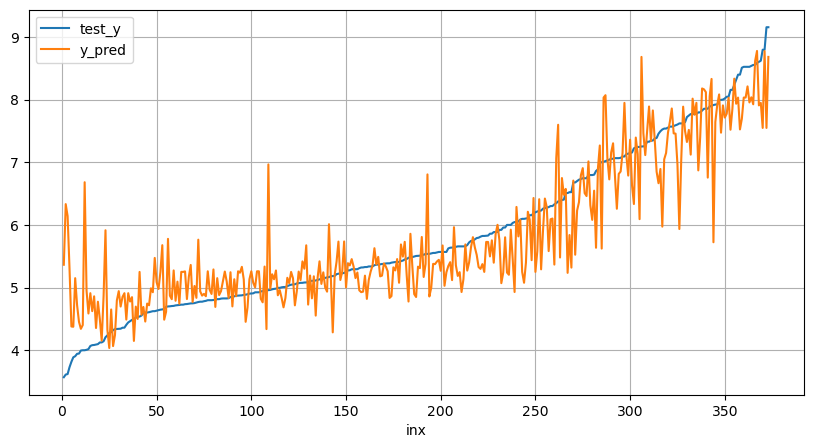

In [50]:
temp_df=pd.DataFrame(zip(ecfp_y_test,y_pred),columns=['test_y','y_pred'])
temp_df=temp_df.sort_values('test_y')
inx=[k for k in range(1,len(ecfp_y_test)+1)]
temp_df['inx']=inx
temp_df.plot(x='inx', y=['test_y','y_pred'], figsize=(10,5), grid=True)

metrices for model evaluation

In [51]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
mse = mean_squared_error(ecfp_y_test, y_pred)

mae = mean_absolute_error(ecfp_y_test, y_pred)

r2 = r2_score(ecfp_y_test,y_pred)

n=ecfp_X_test.shape[1] # number of features/ independent features
k=1  # number of dependent features
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print("adj_r2_score:",adj_r2_score,"r2:",r2,"mae:",mae,"mse:",mse)

adj_r2_score: 0.7891711019227168 r2: 0.7893771907771423 mae: 0.40938211824559945 mse: 0.3382790132633368


## MACCS data with RandomForestRegressor

In [52]:
maccs_final_data = pd.read_csv("Chembl_pIC50_maccs.csv")
maccs_final_data.head()

,SMILES,pIC50,0,1,2,3,4,5,6,7,...,157,158,159,160,161,162,163,164,165,166
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [53]:
maccs_final_data_x = maccs_final_data.drop(["SMILES","pIC50"],axis=1)
maccs_final_data_y = maccs_final_data["pIC50"]
maccs_final_data_x.shape,maccs_final_data_y.shape

((1130, 167), (1130,))

In [54]:
maccs_X_train, maccs_X_test, maccs_y_train, maccs_y_test = train_test_split(maccs_final_data_x, maccs_final_data_y, test_size=0.33, random_state=42)

In [55]:
rf_maccs = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
 max_features=0.5, n_jobs=-1, oob_score=True)

In [57]:
rf_maccs.fit(maccs_X_train, maccs_y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [58]:
y_pred_maccs= rf_maccs.predict(maccs_X_test)
preds_maccs = np.stack([t.predict(maccs_X_test) for t in rf_maccs.estimators_])
std_maccs=[np.std(preds_maccs[:,0]) for i in range(len(maccs_X_test))]
pred_Q_maccs=pd.DataFrame(preds_maccs)
quantiles = [0.2, 0.5, 0.8]
actual_pred_maccs = pd.DataFrame()
for q in quantiles:
    print('quantile',q)
    s = pred_Q_maccs.quantile(q=q, axis=1)
    actual_pred_maccs = pd.concat([actual_pred_maccs,s],axis=1,sort=False)
actual_pred_maccs = actual_pred_maccs.round(2)
uncertainty_lower = actual_pred_maccs[0.2]
uncertainty_higher = actual_pred_maccs[0.8]

new_df=pd.DataFrame(zip(maccs_y_test,y_pred_maccs,std_maccs,uncertainty_lower,uncertainty_higher),columns=['y_test','y_pred','std_','uncertainty_lower','uncertainty_higher'])
new_df.head()

c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\e

quantile 0.2
quantile 0.5
quantile 0.8


,y_test,y_pred,std_,uncertainty_lower,uncertainty_higher
0,7.578396,7.580734,0.445952,4.87,7.38
1,4.798603,4.840404,0.445952,4.90,7.27
2,6.102373,5.331636,0.445952,4.85,7.19
3,5.886057,6.125441,0.445952,4.73,6.98
4,4.692504,4.214701,0.445952,4.94,7.33


<AxesSubplot:xlabel='inx'>

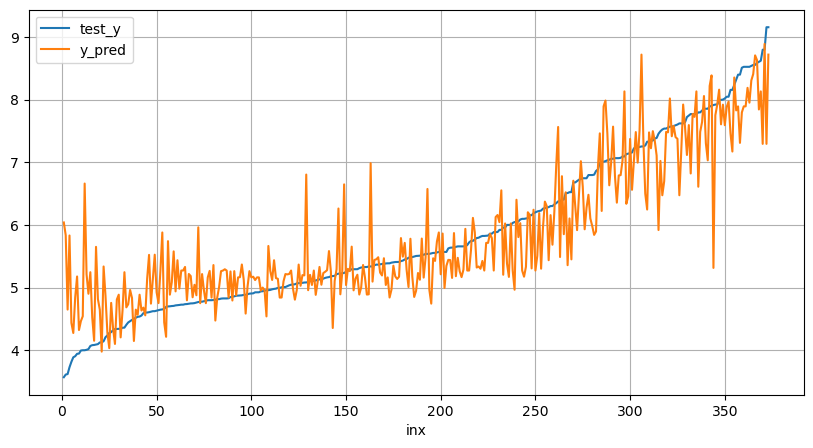

In [69]:
temp_df=pd.DataFrame(zip(maccs_y_test,y_pred_maccs),columns=['test_y','y_pred'])
temp_df=temp_df.sort_values('test_y')
inx=[k for k in range(1,len(maccs_y_test)+1)]
temp_df['inx']=inx
temp_df.plot(x='inx', y=['test_y','y_pred'], figsize=(10,5), grid=True)

metrices for model evaluation

In [61]:
mse = mean_squared_error(maccs_y_test, y_pred_maccs)

mae = mean_absolute_error(maccs_y_test, y_pred_maccs)

r2 = r2_score(maccs_y_test,y_pred_maccs)

n=maccs_X_test.shape[1] # number of features/ independent features
k=1  # number of dependent features
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print("adj_r2_score:",adj_r2_score,"r2:",r2,"mae:",mae,"mse:",mse)

adj_r2_score: 0.7741787220976636 r2: 0.7755390912416535 mae: 0.43115316614401566 mse: 0.36050423508796786


## physciochem data with RandomForestRegressor without StandardScaler

In [62]:
physchem_final_data = pd.read_csv("Chembl_pIC50_physchem.csv")
physchem_final_data.head()

,SMILES,pIC50,weight,logp,h_bond_donor,h_bond_acceptors,rotatable_bonds,atoms,heavy_atoms,molar_refractivity,topological_polar_surface_area,formal_charge,rings
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.301030,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.568636,299.101371,3.2412,1.0,3.0,3.0,19.0,19.0,77.6575,46.17,0.0,3.0
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.744727,311.135528,3.3188,1.0,2.0,3.0,21.0,21.0,79.7385,46.17,0.0,3.0
3,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.958607,327.105978,3.8331,1.0,2.0,3.0,21.0,21.0,84.7905,46.17,0.0,3.0
4,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.000000,371.055462,3.9422,1.0,2.0,3.0,21.0,21.0,87.4805,46.17,0.0,3.0


In [63]:
physchem_final_data_x = physchem_final_data.drop(["SMILES","pIC50"],axis=1)
physchem_final_data_y = physchem_final_data["pIC50"]
physchem_final_data_x.shape,physchem_final_data_y.shape

((1130, 11), (1130,))

In [64]:
physchem_X_train, physchem_X_test, physchem_y_train, physchem_y_test = train_test_split(physchem_final_data_x, physchem_final_data_y, test_size=0.33, random_state=42)

In [65]:
rf_physchem = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
 max_features=0.5, n_jobs=-1, oob_score=True)

In [67]:
rf_physchem.fit(physchem_X_train, physchem_y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [68]:
y_pred_physchem= rf_physchem.predict(physchem_X_test)
preds_physchem = np.stack([t.predict(physchem_X_test) for t in rf_physchem.estimators_])
std_physchem=[np.std(preds_physchem[:,0]) for i in range(len(physchem_X_test))]
pred_Q_physchem=pd.DataFrame(preds_physchem)
quantiles = [0.2, 0.5, 0.8]
actual_pred_physchem = pd.DataFrame()
for q in quantiles:
    print('quantile',q)
    s = pred_Q_physchem.quantile(q=q, axis=1)
    actual_pred_physchem = pd.concat([actual_pred_physchem,s],axis=1,sort=False)
actual_pred_physchem = actual_pred_physchem.round(2)
uncertainty_lower = actual_pred_physchem[0.2]
uncertainty_higher = actual_pred_physchem[0.8]

new_df=pd.DataFrame(zip(physchem_y_test,y_pred_physchem,std_physchem,uncertainty_lower,uncertainty_higher),columns=['y_test','y_pred','std_','uncertainty_lower','uncertainty_higher'])
new_df.head()

c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\envs\qsar\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\kiran.franklin\Anaconda3\e

quantile 0.2
quantile 0.5
quantile 0.8


,y_test,y_pred,std_,uncertainty_lower,uncertainty_higher
0,7.578396,6.546215,0.926248,4.85,6.61
1,4.798603,4.756579,0.926248,4.83,7.35
2,6.102373,5.257547,0.926248,4.89,6.84
3,5.886057,5.698170,0.926248,4.82,7.05
4,4.692504,4.633757,0.926248,4.84,7.28


<AxesSubplot:xlabel='inx'>

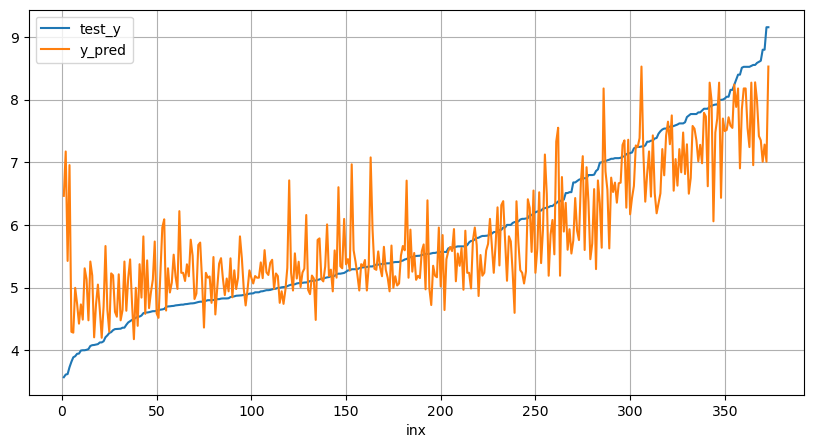

In [70]:
temp_df=pd.DataFrame(zip(physchem_y_test,y_pred_physchem),columns=['test_y','y_pred'])
temp_df=temp_df.sort_values('test_y')
inx=[k for k in range(1,len(physchem_y_test)+1)]
temp_df['inx']=inx
temp_df.plot(x='inx', y=['test_y','y_pred'], figsize=(10,5), grid=True)

In [71]:
mse = mean_squared_error(physchem_y_test, y_pred_physchem)

mae = mean_absolute_error(physchem_y_test, y_pred_physchem)

r2 = r2_score(physchem_y_test,y_pred_physchem)

n=physchem_X_test.shape[1] # number of features/ independent features
k=1  # number of dependent features
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print("adj_r2_score:",adj_r2_score,"r2:",r2,"mae:",mae,"mse:",mse)

adj_r2_score: 0.6417752806119332 r2: 0.6775977525507398 mae: 0.5313605076877097 mse: 0.5178067586479708


## physciochem data with RandomForestRegressor with StandardScaler

In [72]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
physchem_X_train_transformed=sc.fit_transform(physchem_X_train)
physchem_X_test_transformed=sc.transform(physchem_X_test)

In [73]:
rf_physchem_transform = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
 max_features=0.5, n_jobs=-1, oob_score=True)

In [74]:
rf_physchem_transform.fit(physchem_X_train_transformed, physchem_y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [76]:
y_pred_physchem_transformed= rf_physchem_transform.predict(physchem_X_test_transformed)
preds_physchem_transformed = np.stack([t.predict(physchem_X_test_transformed) for t in rf_physchem_transform.estimators_])
std_physchem_transformed=[np.std(preds_physchem_transformed[:,0]) for i in range(len(physchem_X_test_transformed))]
pred_Q_physchem_transformed=pd.DataFrame(preds_physchem_transformed)
quantiles = [0.2, 0.5, 0.8]
actual_pred_physchem_transformed = pd.DataFrame()
for q in quantiles:
    print('quantile',q)
    s = pred_Q_physchem_transformed.quantile(q=q, axis=1)
    actual_pred_physchem_transformed = pd.concat([actual_pred_physchem_transformed,s],axis=1,sort=False)
actual_pred_physchem_transformed = actual_pred_physchem_transformed.round(2)
uncertainty_lower = actual_pred_physchem_transformed[0.2]
uncertainty_higher = actual_pred_physchem_transformed[0.8]

new_df=pd.DataFrame(zip(physchem_y_test,y_pred_physchem_transformed,std_physchem_transformed,uncertainty_lower,uncertainty_higher),columns=['y_test','y_pred','std_','uncertainty_lower','uncertainty_higher'])
new_df.head()

quantile 0.2
quantile 0.5
quantile 0.8


,y_test,y_pred,std_,uncertainty_lower,uncertainty_higher
0,7.578396,6.724022,1.027036,4.83,6.84
1,4.798603,4.887496,1.027036,4.76,7.02
2,6.102373,5.368022,1.027036,4.96,6.97
3,5.886057,5.665784,1.027036,4.83,7.16
4,4.692504,4.682161,1.027036,4.92,7.17


<AxesSubplot:xlabel='inx'>

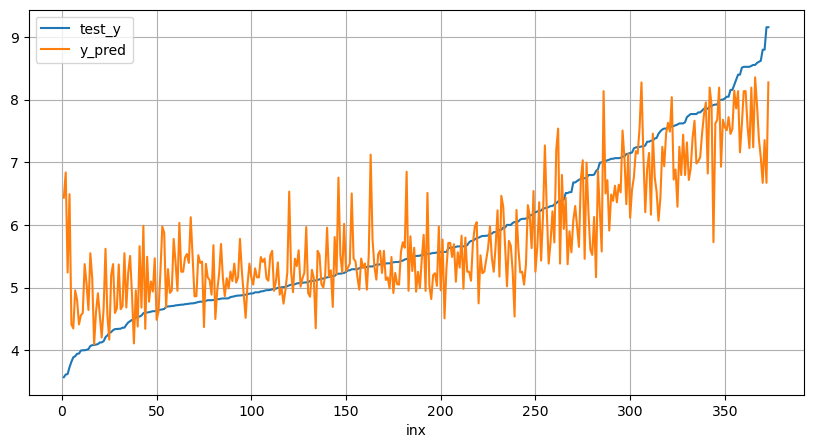

In [77]:
temp_df=pd.DataFrame(zip(physchem_y_test,y_pred_physchem_transformed),columns=['test_y','y_pred'])
temp_df=temp_df.sort_values('test_y')
inx=[k for k in range(1,len(physchem_y_test)+1)]
temp_df['inx']=inx
temp_df.plot(x='inx', y=['test_y','y_pred'], figsize=(10,5), grid=True)

In [78]:
mse = mean_squared_error(physchem_y_test, y_pred_physchem_transformed)

mae = mean_absolute_error(physchem_y_test, y_pred_physchem_transformed)

r2 = r2_score(physchem_y_test,y_pred_physchem_transformed)

n=physchem_X_test_transformed.shape[1] # number of features/ independent features
k=1  # number of dependent features
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print("adj_r2_score:",adj_r2_score,"r2:",r2,"mae:",mae,"mse:",mse)

adj_r2_score: 0.6402165164658918 r2: 0.6761948648193027 mae: 0.5432362789742454 mse: 0.5200599214429256


|                 | ECFP            |MACCS            |physchem without std scaler|physchem with std scaler|
|-----------------|-----------------|-----------------|---------------------------|------------------------|
| adj_r2_score    | 0.7891711019227168 |0.7741787220976636   |0.6417752806119332         | 0.6402165164658918     |
| r2              | 0.7893771907771423   |0.7755390912416535   |0.6775977525507398         | 0.6761948648193027     |
|mae              | 0.40938211824559945   |0.43115316614401566  |0.5313605076877097         | 0.5432362789742454     |
|mse              |0.3382790132633368  |0.36050423508796786     |0.5178067586479708         |0.5200599214429256      |
